#### IMPORTING NECESSARY LIBRARIES

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums, mannwhitneyu, median_abs_deviation

from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models, get_prob_mat
from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram
from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures

#### SIMULATING ONE BIOMARKER DATA

In [16]:
def sigmoid_function(a,b,x):
    return 1/(1+np.exp(a*(b-x)))

In [17]:
onset_time = 10
number_of_patients = 100
time_points = np.linspace(0,20,number_of_patients)

patient_data = np.empty(number_of_patients)
noise_std = 0.1

for index in range(len(time_points)):
    time = time_points[index]
    biomarker_value = sigmoid_function(1,onset_time,time)
    noise = np.random.normal(0,noise_std)
    patient_data[index] = biomarker_value + noise

Text(0, 0.5, 'Hypothetical Biomarker value')

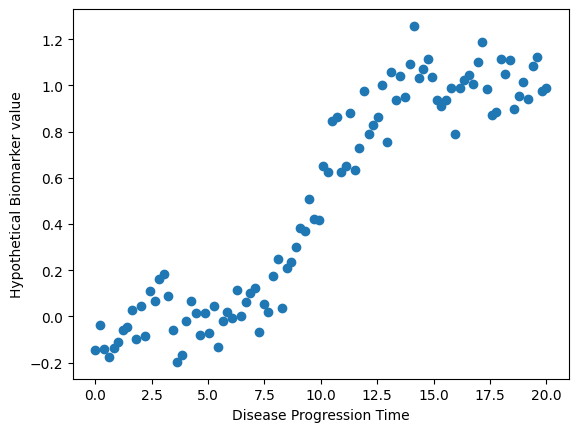

In [18]:
plt.scatter(x=time_points,y=patient_data)
plt.xlabel("Disease Progression Time")
plt.ylabel("Hypothetical Biomarker value")

#### SIMULATING MULITPLE BIOMARKERS DATA

In [19]:
def sigmoid_function(a,b,x):
    return 1/(1+np.exp(a*(b-x)))

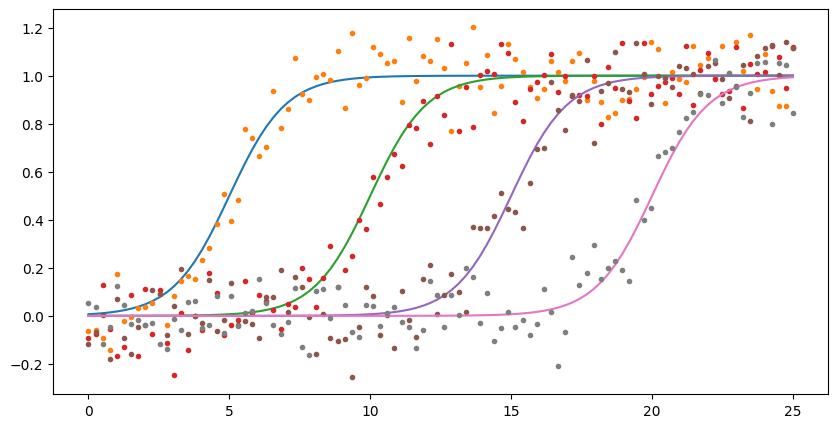

In [20]:
number_of_patients = 100
number_of_biomarkers = 4
onset_times = [5,10,15,20]
time_points = np.linspace(0,25,number_of_patients)

patient_data = np.empty(shape=(number_of_patients,number_of_biomarkers))
noise_value = 0.1
fig,ax = plt.subplots(figsize=(10,5))

for onset_time,biomarker_number in zip(onset_times,range(number_of_biomarkers)):
    biomarker_values = sigmoid_function(1,onset_time,time_points)
    ax.plot(time_points, biomarker_values)
    
    noise = np.random.normal(0,noise_value,len(time_points))
    biomarker_values+=noise
    ax.plot(time_points, biomarker_values,'.')
    
    patient_data[:,biomarker_number] = biomarker_values

#### SIMULATING CONTROL DATA

In [11]:
control_data = np.empty(shape=(number_of_patients,number_of_biomarkers))
for biomarker_number in range(number_of_biomarkers):
    control_data[:,biomarker_number] = np.random.normal(0,0.05,number_of_patients)

#### HISTOGRAM OF BIOMARKER VALUES IN PATIENT VS CONTROL SUBPOPULATION

##### A significant difference suggests the presence of a disease signal in a biomarker

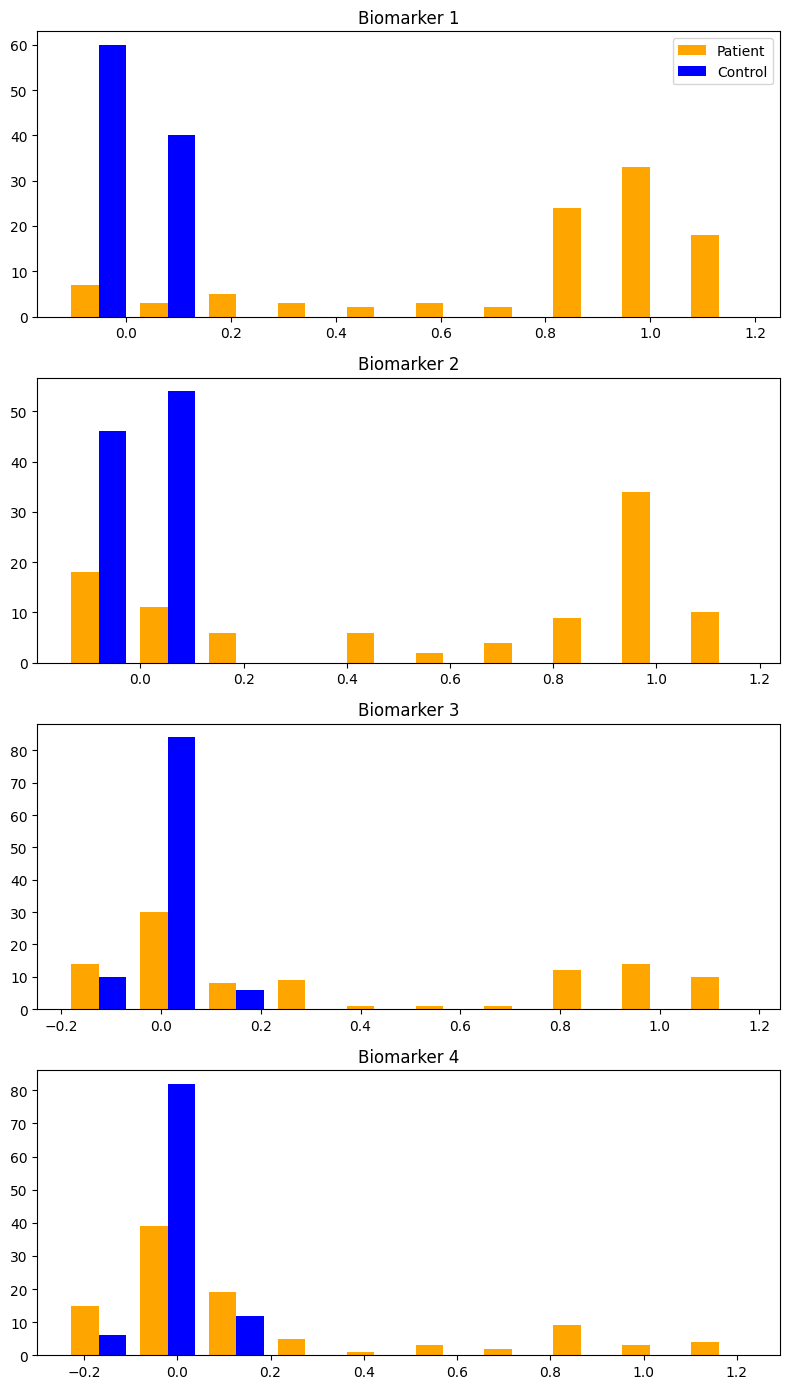

In [12]:
fig,ax = plt.subplots(4,1,figsize=(8,14))
for biomarker_number in range(number_of_biomarkers):
    ax[biomarker_number].hist([patient_data[:,biomarker_number],control_data[:,biomarker_number]],label=['Patient','Control'],color=['orange','blue'])
    ax[biomarker_number].set_title('Biomarker '+ str(biomarker_number+1))
ax[0].legend()
fig.tight_layout()

#### MANN-WHITNEY U TEST (WILCOXON RANK-SUM TEST)

In [13]:
print('Mann Whitney U Test')
for biomarker_number in range(number_of_biomarkers):
    patient_biomarker_data = patient_data[:,biomarker_number]
    control_biomarker_data = control_data[:,biomarker_number]
    print('\nBiomarker '+str(biomarker_number+1))
    statistic,p_value = mannwhitneyu(patient_biomarker_data,control_biomarker_data)
    print('U:',statistic,' P-value:',p_value)   

Mann Whitney U Test

Biomarker 1
U: 9431.0  P-value: 2.6083914711182164e-27

Biomarker 2
U: 8194.0  P-value: 6.0470566084716395e-15

Biomarker 3
U: 7612.0  P-value: 1.7603865736961706e-10

Biomarker 4
U: 6167.0  P-value: 0.004368994120023425


#### CALCULATING EFFECT SIZE (COHEN'S D)

In [14]:
for biomarker_number in range(number_of_biomarkers):
    patient_biomarker_data = patient_data[:,biomarker_number]
    control_biomarker_data = control_data[:,biomarker_number]
    effect_size = np.absolute(np.mean(patient_biomarker_data)-np.mean(control_biomarker_data))/median_abs_deviation(control_biomarker_data)
    print('Biomarker '+str(biomarker_number+1),' Effect Size: ',effect_size)

Biomarker 1  Effect Size:  23.898181795341213
Biomarker 2  Effect Size:  16.83799687066536
Biomarker 3  Effect Size:  11.599041323298072
Biomarker 4  Effect Size:  4.986497427590204


#### DATA PRE-PROCESSING

In [11]:
Y_patients = np.ones(shape=(number_of_patients,1))
Y_controls = np.zeros(shape=(number_of_patients,1))

X = np.concatenate((patient_data,control_data),axis=0)
Y = np.concatenate((Y_patients,Y_controls),axis=0).flatten().astype(int)

#### FITTING MIXTURE MODELS

In [12]:
# Labelling the Biomarkers/Events
events = ['Early','Early-ish','Late-ish','Late']
event_labels = events

# Direction of progression (1 = Biomarker increases in patients; -1 = Biomarker decreases in patients)
#  This is a feature of the KDE EBM software.

events_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
events_disease_direction = [events_disease_direction_dict[x] for x in events]

In [13]:
KDE_mixtures = fit_all_kde_models(X, Y,implement_fixed_controls = True, patholog_dirn_array = events_disease_direction)

(<Figure size 1200x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Early'}>,
         <Axes: title={'center': 'Early-ish'}>],
        [<Axes: title={'center': 'Late-ish'}>,
         <Axes: title={'center': 'Late'}>]], dtype=object))

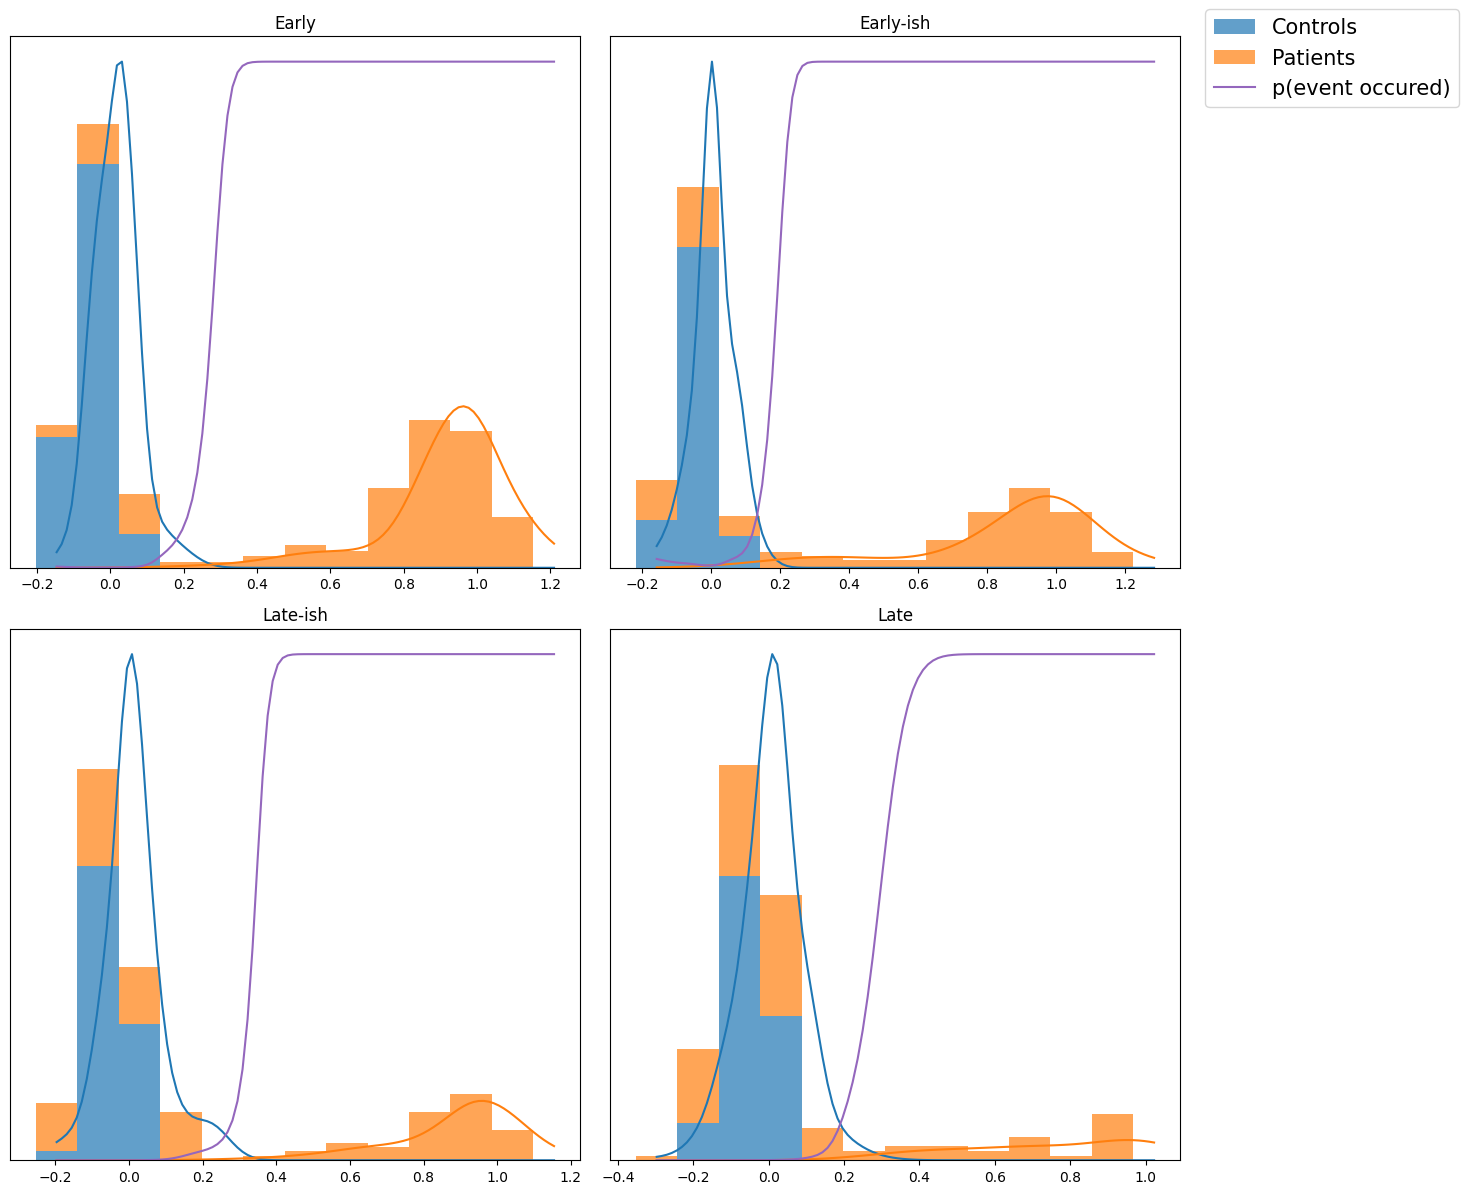

In [15]:
mixture_model_grid(X,Y, KDE_mixtures, score_names=events, class_names=['Controls','Patients'])

#### SEQUENCING USING MCMC

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5709.98it/s]
C:\Users\ramya\dpm\Lib\site-packages\kde_ebm\mcmc\mcmc.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4284.99it/s]


ML order   : Early, Early-ish, Late-ish, Late


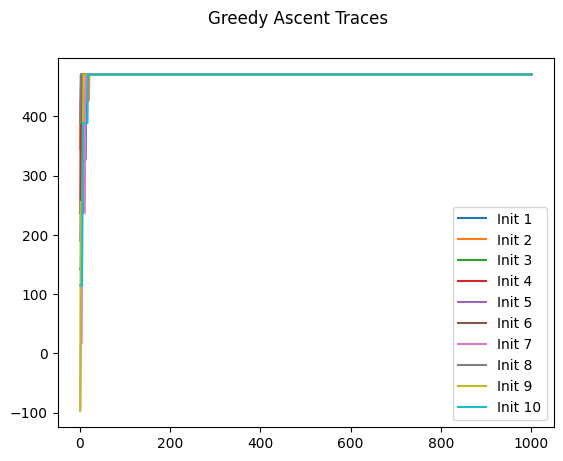

In [16]:
# MCMC sequencing
mcmc_samples = mcmc(X, KDE_mixtures)

#* Maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering

print('ML order   : %s' % ', '.join([event_labels[k] for k in seq_ml]))

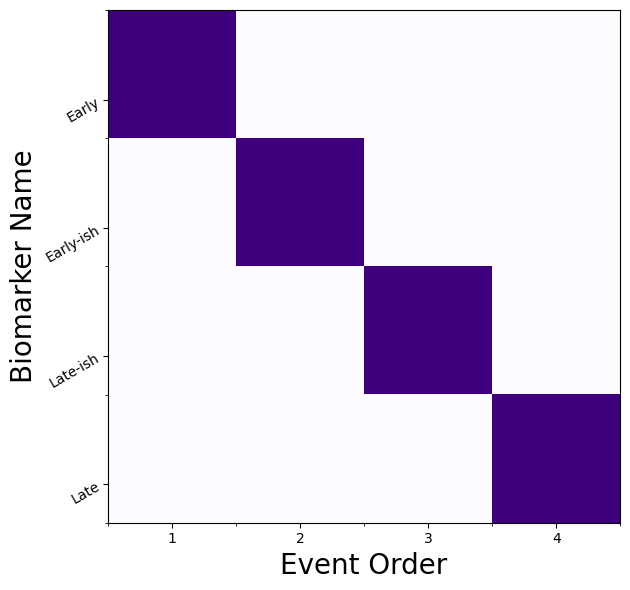

In [17]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=event_labels)

In [2]:
from kde_ebm import mixture_model
from kde_ebm import mcmc
from kde_ebm import plotting
from kde_ebm import datasets
from kde_ebm import distributions
from matplotlib import pyplot as plt

In [3]:
fig, ax = plotting.mixture_model_grid(X, y, mixture_models, score_names=events, class_names=['Controls','Patients'])
fig.show()

NameError: name 'X' is not defined

In [ ]:

samples = mcmc.mcmc(X, mixture_models, n_iter=200, greedy_n_iter=10, greedy_n_init=2)
samples.sort(reverse=True)
ml_order = samples[0]
fig, ax = plotting.mcmc_uncert_mat(samples, score_names=bmname)
fig.show()

In [ ]:
    bs_samples = mcmc.bootstrap_ebm(X, y, n_mcmc_iter=200,
                                    n_bootstrap=10, greedy_n_init=2,
                                    greedy_n_iter=10)
    for bs_k,bs in enumerate(bs_samples):
        fig, ax = plotting.mcmc_uncert_mat(bs, ml_order=ml_order,
                                           score_names=bmname)
        ax.set_title(f"Bootstrap {bs_k+1}")
        fig.tight_layout()
        fig.show()
    plt.show()